Statevector([ 0.00000000e+00+0.j        ,  4.08248290e-01+0.40824829j,
              3.53525080e-17+0.57735027j,  0.00000000e+00+0.j        ,
             -1.06057524e-16-0.57735027j,  0.00000000e+00+0.j        ,
              0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
            dims=(2, 2, 2))
probs: {'001': 0.3333333333333334, '010': 0.3333333333333333, '100': 0.3333333333333333}


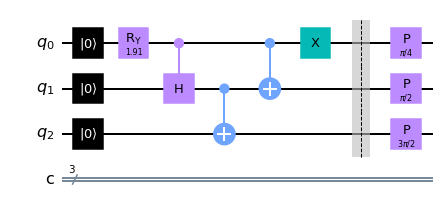

In [3]:
import math as m
import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector


def changePhase(circuit, phases): 
    for p in phases:
        if p<0 or p>2*m.pi:
            raise Exception('The phases must be between 0 and 2pi.')
            
    _circuit = circuit.copy()
    for i in range(len(phases)):
        if phases[i] != 0:
            _circuit.p(phases[i],i)
    return _circuit
        
def buildWState(circuit, referencePosition: int, n: int):
    if (n < 2):
        raise Exception('The size must be at least two.')
    if (referencePosition < 0):
        raise Exception('The reference position must be at least zero.')
    if (n > circuit.width() / 2):
        raise Exception('The circuit does not have enough qubits.')
    if (referencePosition + n > circuit.width() / 2):
        raise Exception('The reference position must be lower.')
    firstPosition = referencePosition
    lastPosition = referencePosition + n - 1
    _circuit = circuit.copy()
    for i in range(firstPosition, lastPosition + 1):
        _circuit.reset(i)
    if (n >= 3):
        _circuit.ry(2 * np.arccos(1 / m.sqrt(n)), firstPosition)
        for i in range(n - 3):
            _circuit.cry(2 * np.arccos(1 / m.sqrt(n - (i + 1))), firstPosition + i, firstPosition + i + 1)
    if (n == 2):
        _circuit.h(firstPosition)
    else:
        _circuit.ch(lastPosition - 2, lastPosition - 1)
    for i in reversed(range(firstPosition, lastPosition)):
        _circuit.cx(i, i + 1)
    _circuit.x(firstPosition)
    
    return _circuit

# Use Aer's qasm_simulator
simulator = QasmSimulator()

# Create a Quantum Circuit acting on the q register
q = 3
phases = [m.pi/4,m.pi/2,3*m.pi/2]
assert len(phases)==q,'A phase for each qbit is needed.' 

circuit = QuantumCircuit(q,q)
circuit = buildWState(circuit, 0, 3)
circuit.barrier()
circuit = changePhase(circuit, phases)

psi = Statevector.from_instruction(circuit)
print(psi.draw())
# Probabilities for measuring qubits
probs = psi.probabilities_dict()
print('probs: {}'.format(probs))

# Compile the circuit down to low-level QASM instructions
# supported by the backend
compiled_circuit = transpile(circuit,simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=1000)

#Grab results from the job
results = job.result()

# Draw the circuit
circuit.draw()